# Scanpy and Episcanpy processing of 10X multimodal PBMC dataset

Here we present all the steps to properly analyze the multimodal dataset with the Cole Trapnell Lab tools.

DATA available at:
https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-controller-1-standard-2-0-0

Filtered feature barcode matrix MEX (DIR)

Filtered feature barcode matrix (HDF5)

ATAC peak locations (BED)

One needs to load all the necessary packages listed below.

In [40]:
import scanpy as sc
import numpy as np
import pandas as pd
import episcanpy as epi
import matplotlib.pyplot as plt

Scanpy uses the AnnData structure to store all the data and the results. Scanpy provides the function to directly read the 10X files, and then divide in two AnnData into the two types of data.

In [6]:
SCANPY_table = sc.read_10x_mtx("../DATA/filtered_feature_bc_matrix/",
                               var_names= "gene_symbols",
                                gex_only= False
                          )

SCANPY_adata_RNA = SCANPY_table[:,SCANPY_table.var.feature_types == "Gene Expression"]

SCANPY_adata_ATAC =SCANPY_table[:,SCANPY_table.var.feature_types == "Peaks"]

In [46]:
SCANPY_adata_RNA

AnnData object with n_obs × n_vars = 10691 × 5594
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Gene Expression data processing and analysis

After that, one can start with the processing of the data. Let's start with the scRNA-seq data separately.

Scanpy provides extensive functions for the Quality Control metrics.

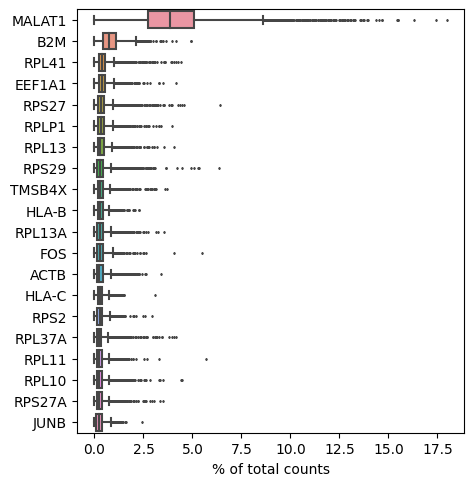

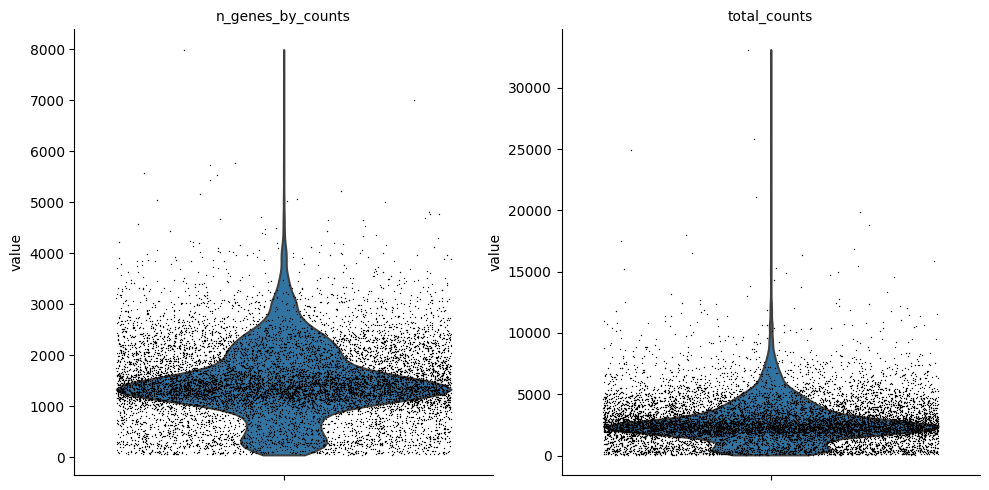

In [9]:
SCANPY_adata_RNA = SCANPY_adata_RNA[:, ~SCANPY_adata_RNA.var_names.str.startswith('MT-')]
sc.pl.highest_expr_genes(SCANPY_adata_RNA, n_top=20, )
sc.pp.calculate_qc_metrics(SCANPY_adata_RNA)
SCANPY_adata_RNA.var['mt'] = SCANPY_adata_RNA.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(SCANPY_adata_RNA, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(SCANPY_adata_RNA, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

Then, one needs to normalize and log transform the data.

In [10]:
sc.pp.normalize_total(SCANPY_adata_RNA, target_sum=1e4)
sc.pp.log1p(SCANPY_adata_RNA)

One can chose to employ only the highly variable features, to retain only the most informative features for the next calculations.

In [11]:
sc.pp.highly_variable_genes(SCANPY_adata_RNA, min_mean=0.0125, max_mean=3, min_disp=0.5)

SCANPY_adata_RNA = SCANPY_adata_RNA[:, SCANPY_adata_RNA.var.highly_variable]
sc.pp.regress_out(SCANPY_adata_RNA, ['total_counts', 'pct_counts_mt'])

Then, the processing starts with scaling and pca.

In [12]:
sc.pp.scale(SCANPY_adata_RNA, max_value=10)
SCANPY_adata_RNA

AnnData object with n_obs × n_vars = 10691 × 5594
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

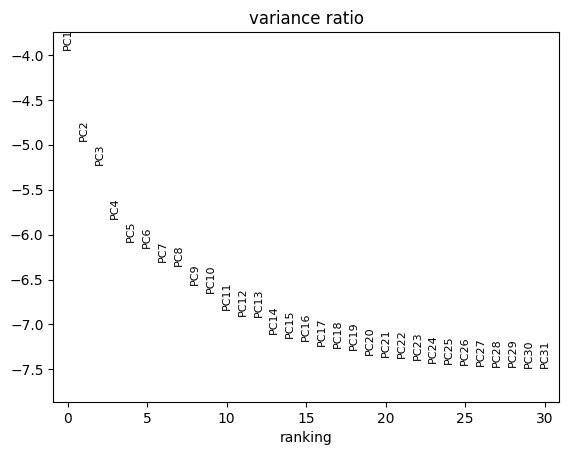

In [13]:
sc.tl.pca(SCANPY_adata_RNA, svd_solver='arpack')
sc.pl.pca_variance_ratio(SCANPY_adata_RNA, log=True)

It follows the neighbours graph creation and the UMAP visualization

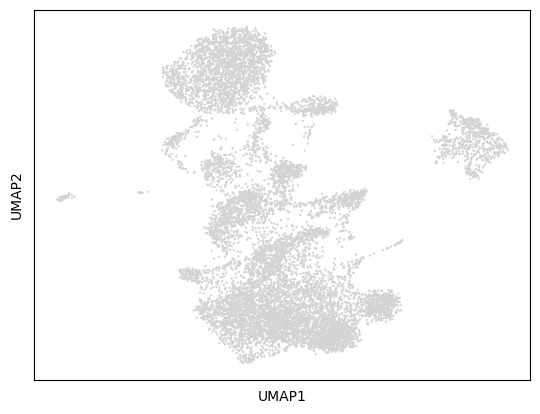

In [14]:
sc.pp.neighbors(SCANPY_adata_RNA, n_neighbors=20, n_pcs=40)
sc.tl.umap(SCANPY_adata_RNA)
sc.pl.umap(SCANPY_adata_RNA)

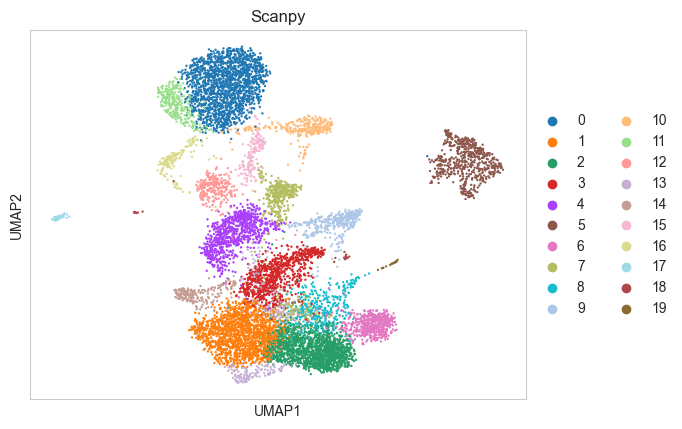

In [47]:
sc.tl.leiden(SCANPY_adata_RNA)
sc.pl.umap(SCANPY_adata_RNA, color = 'leiden', title=  'Scanpy')

Scanpy provides different type of test to perform the differential analysis

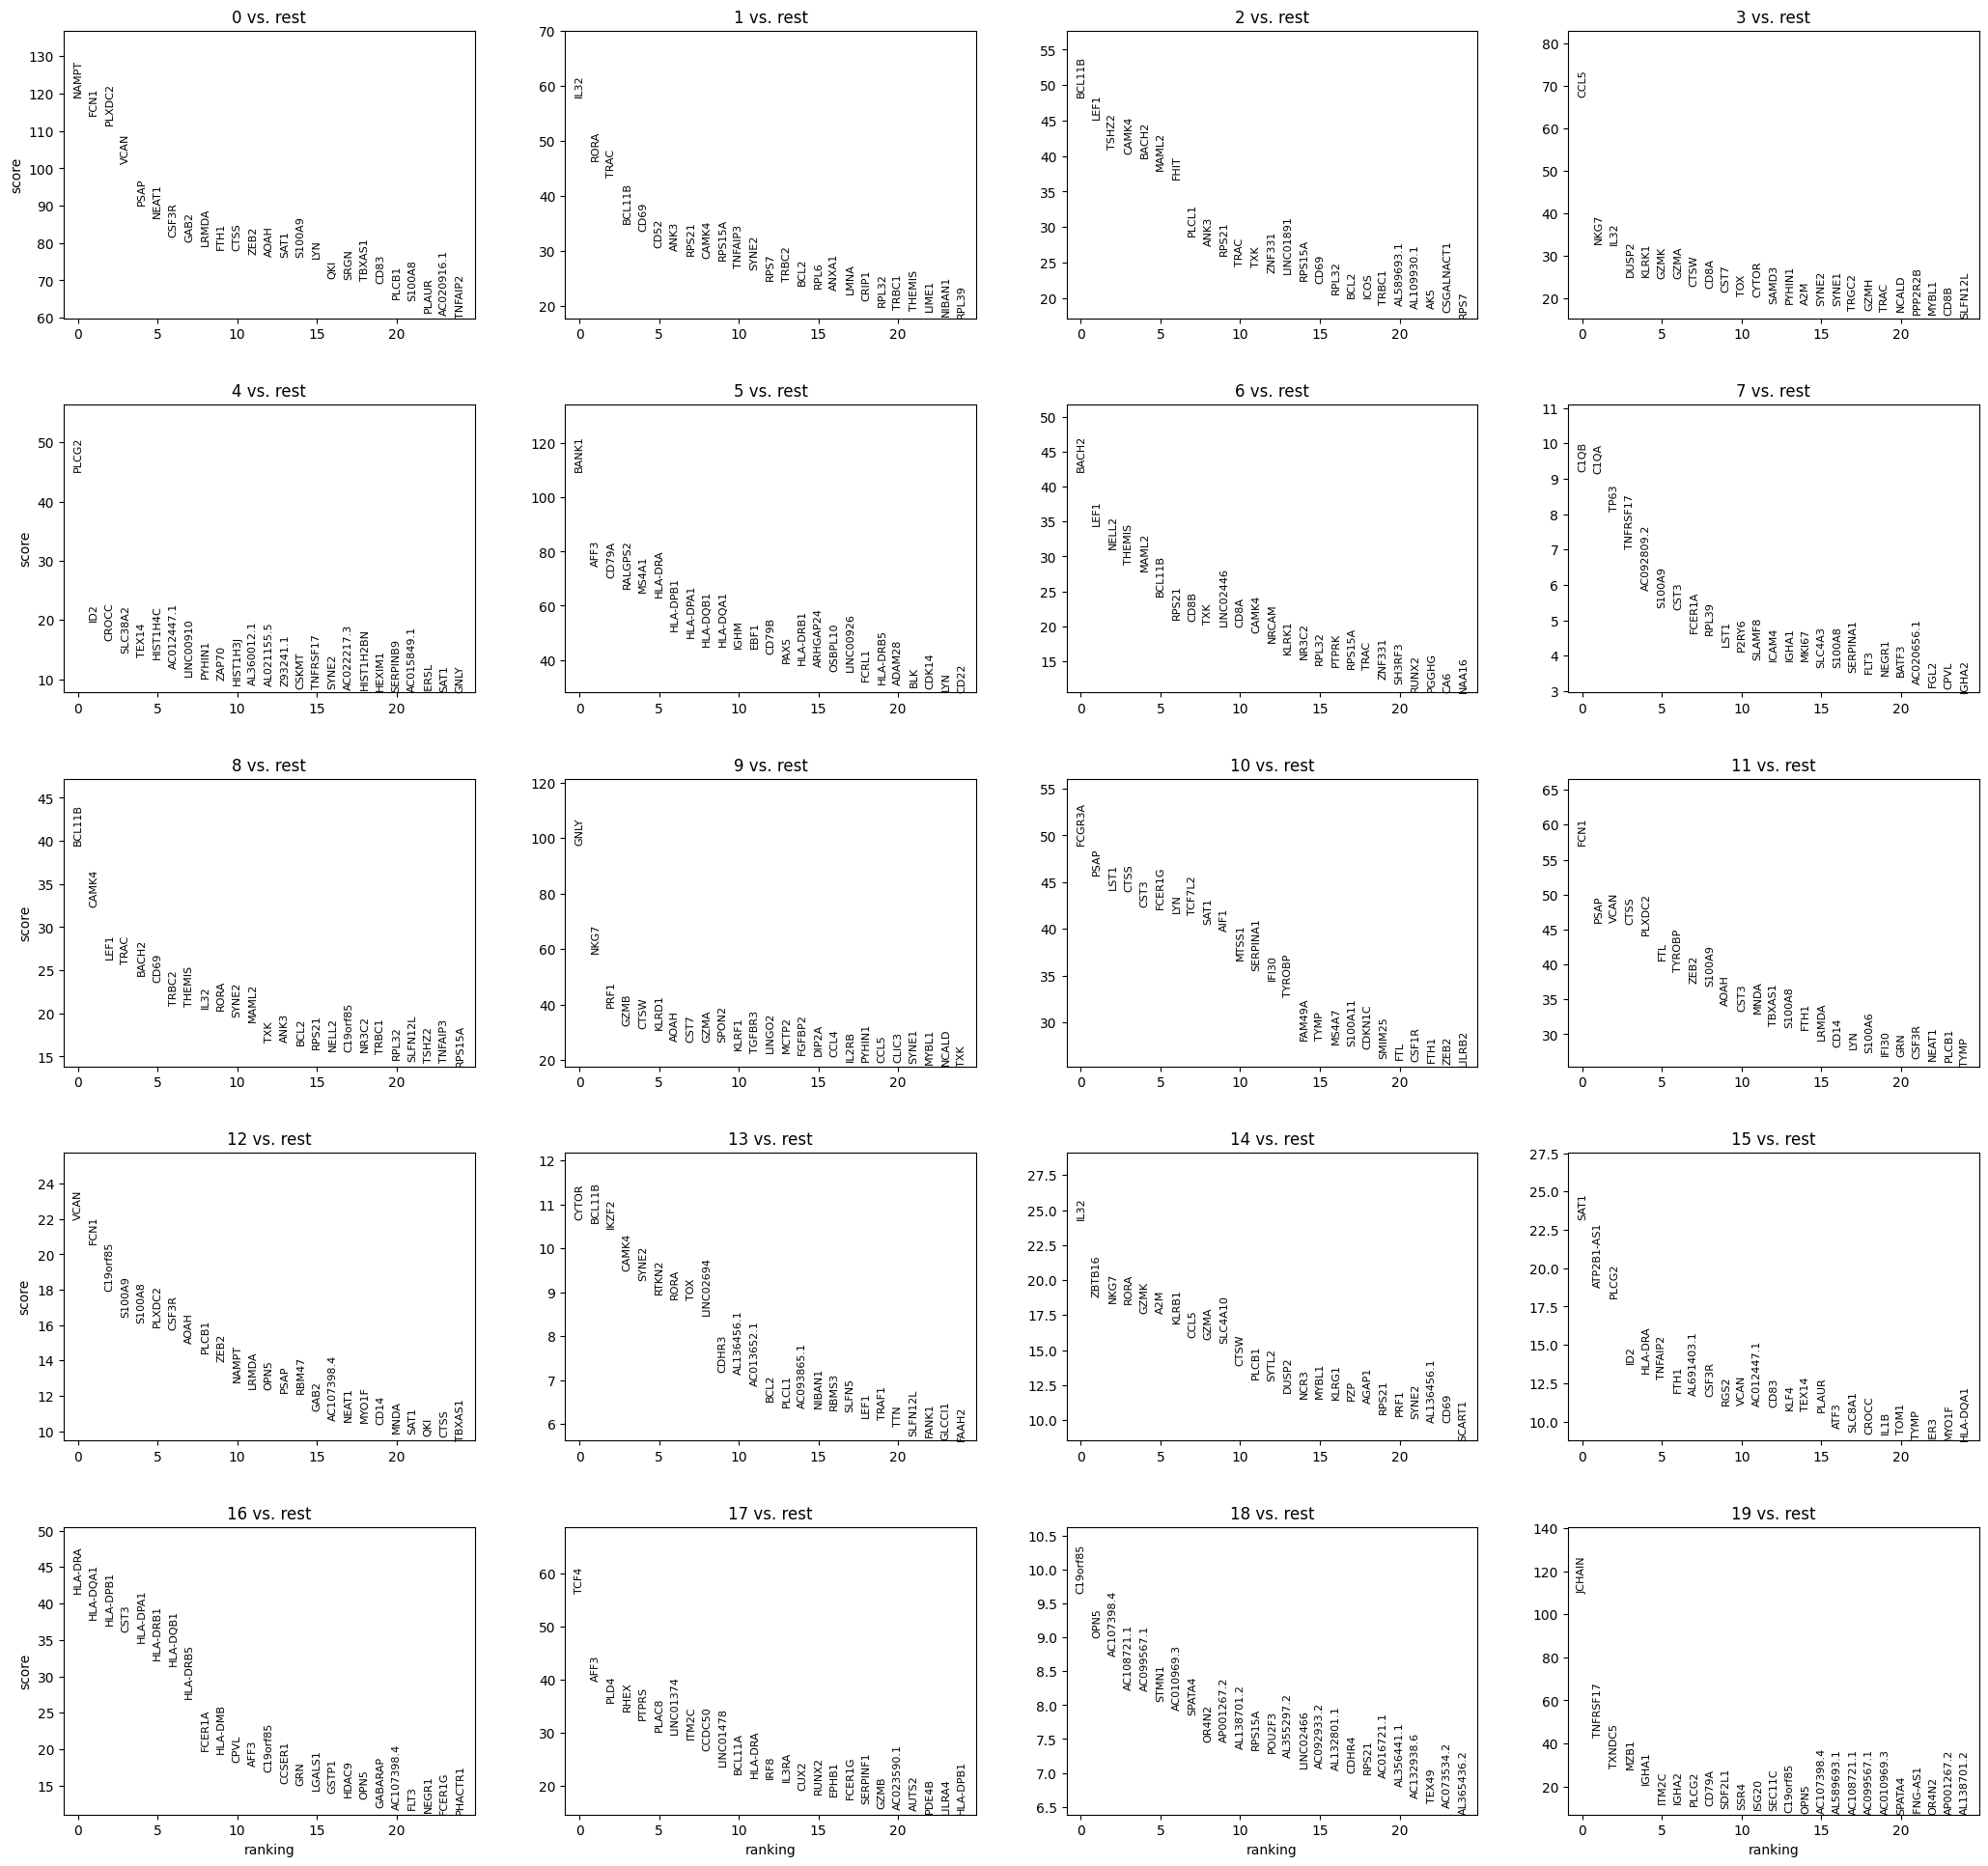

In [19]:
sc.tl.rank_genes_groups(SCANPY_adata_RNA, 'leiden', method='t-test')
sc.pl.rank_genes_groups(SCANPY_adata_RNA, n_genes=25, sharey=False)

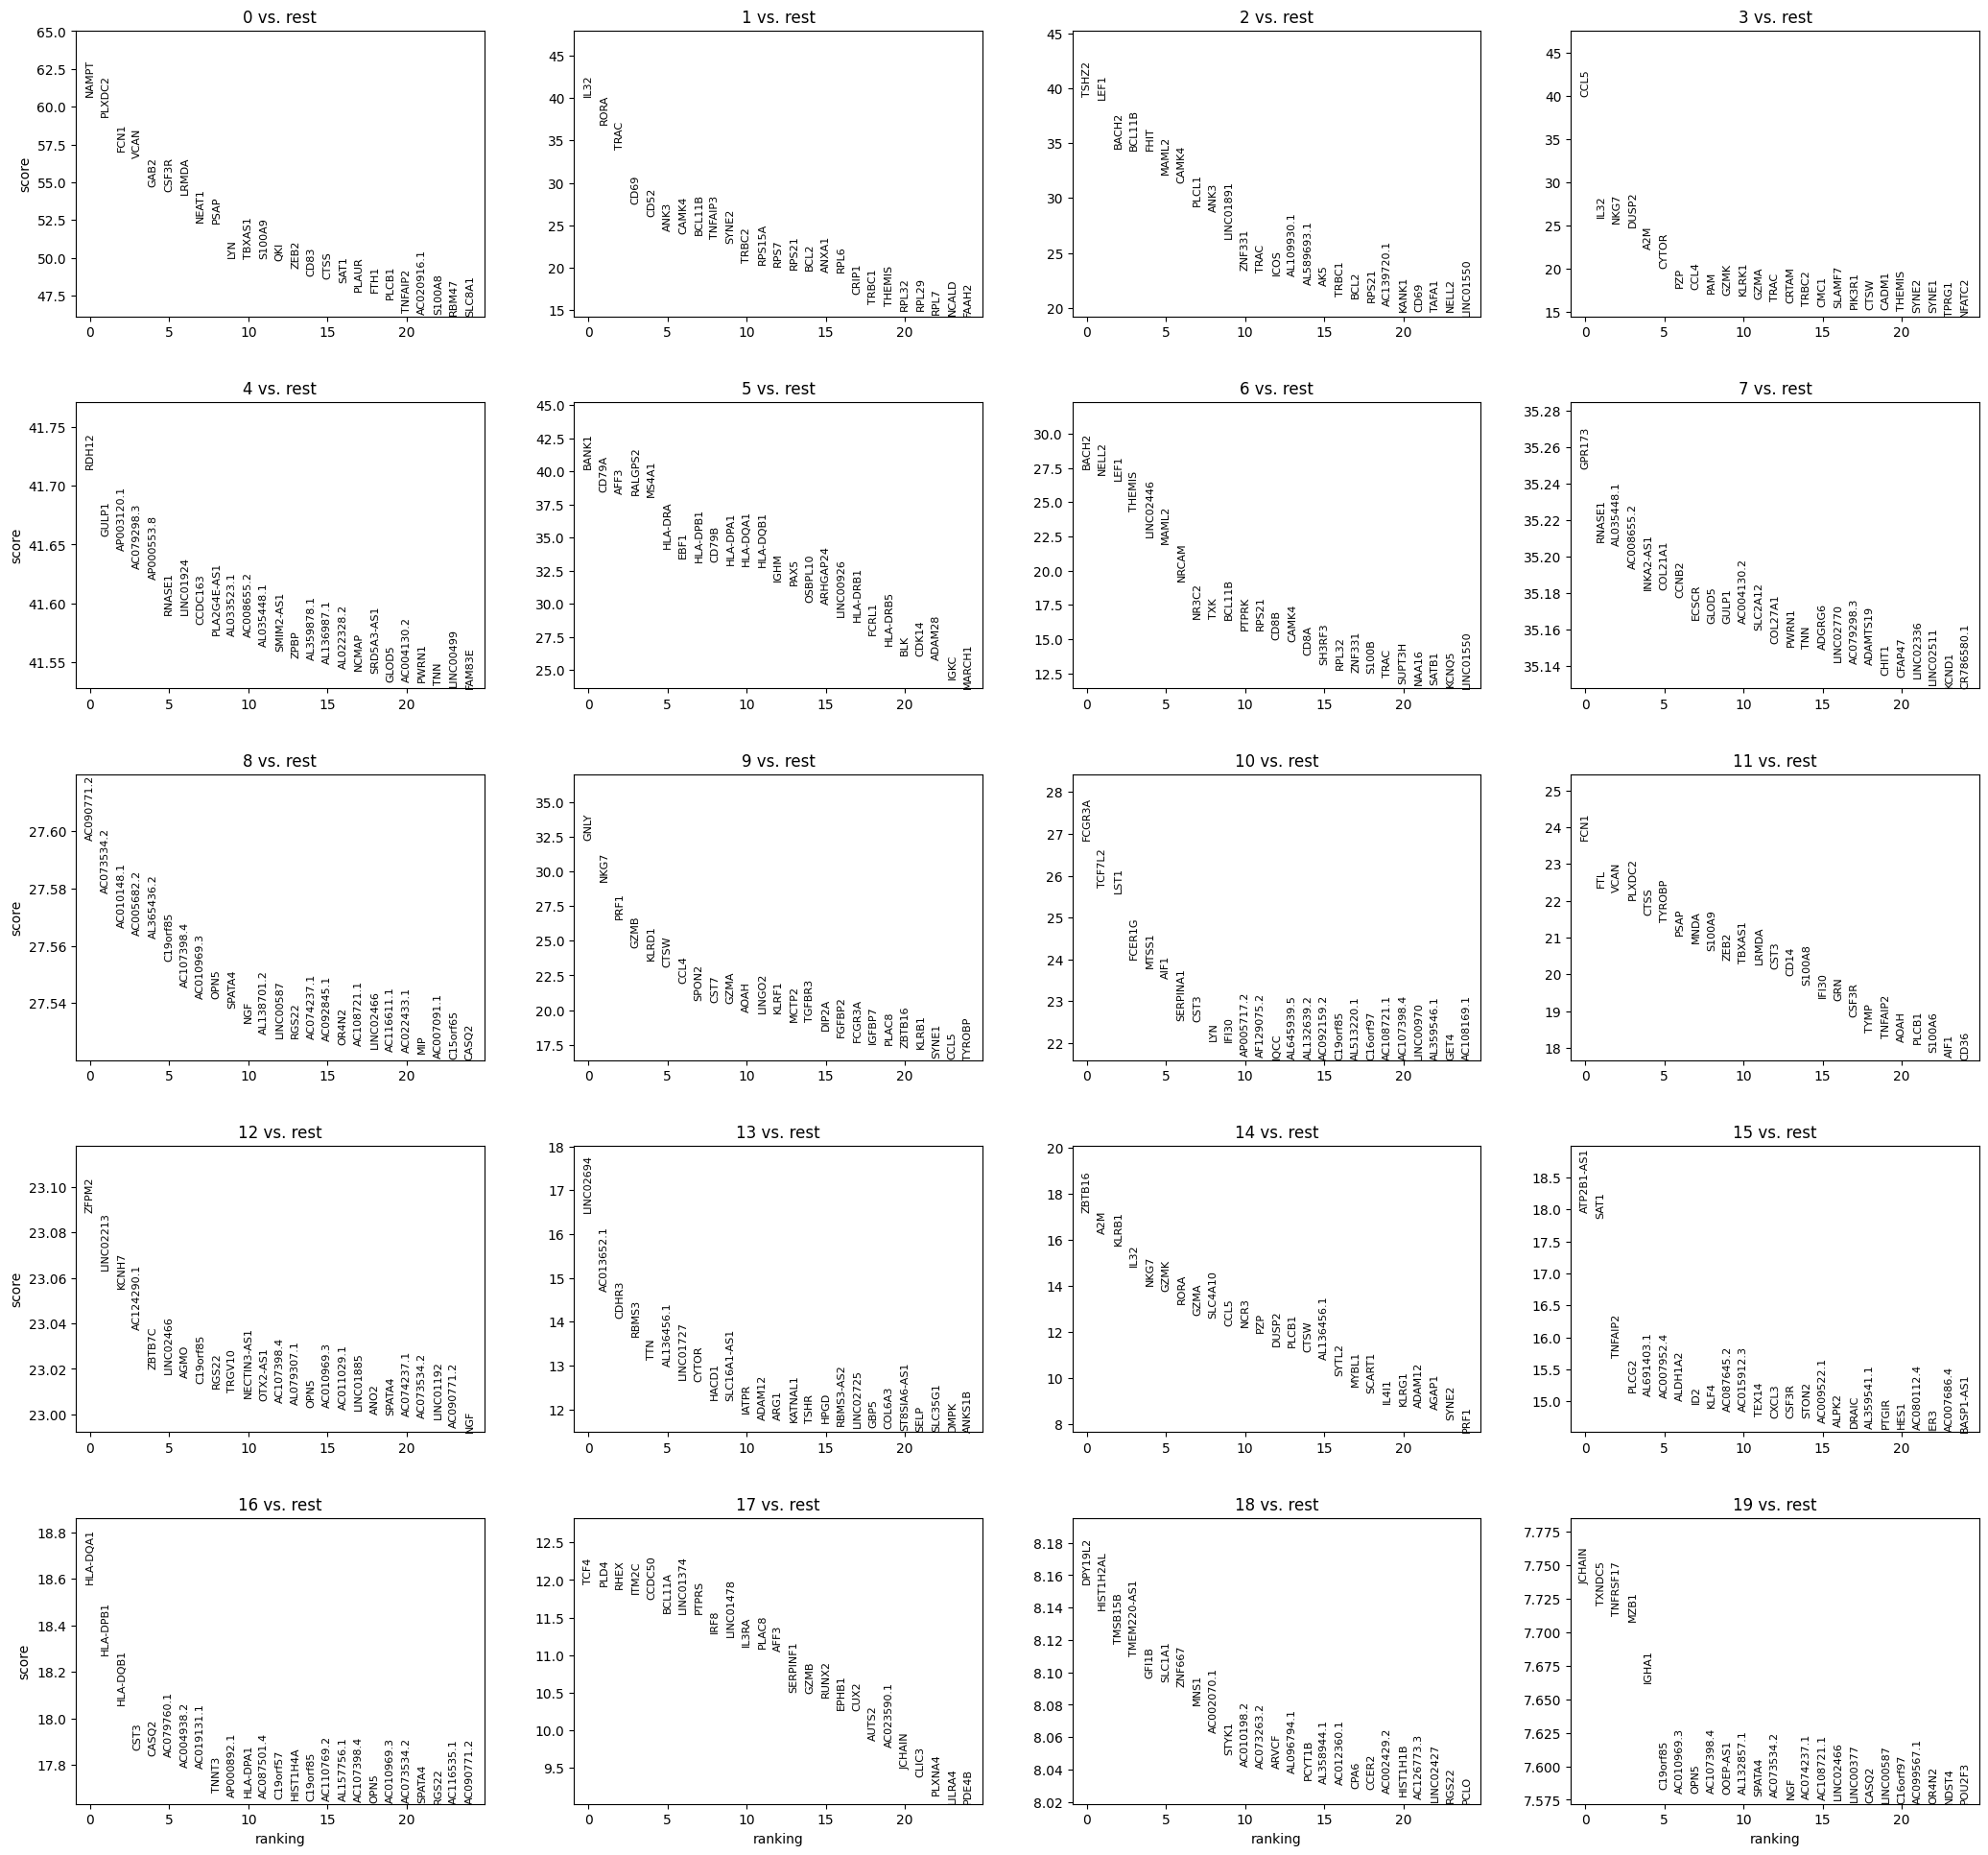

In [20]:
sc.tl.rank_genes_groups(SCANPY_adata_RNA, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(SCANPY_adata_RNA, n_genes=25, sharey=False)

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


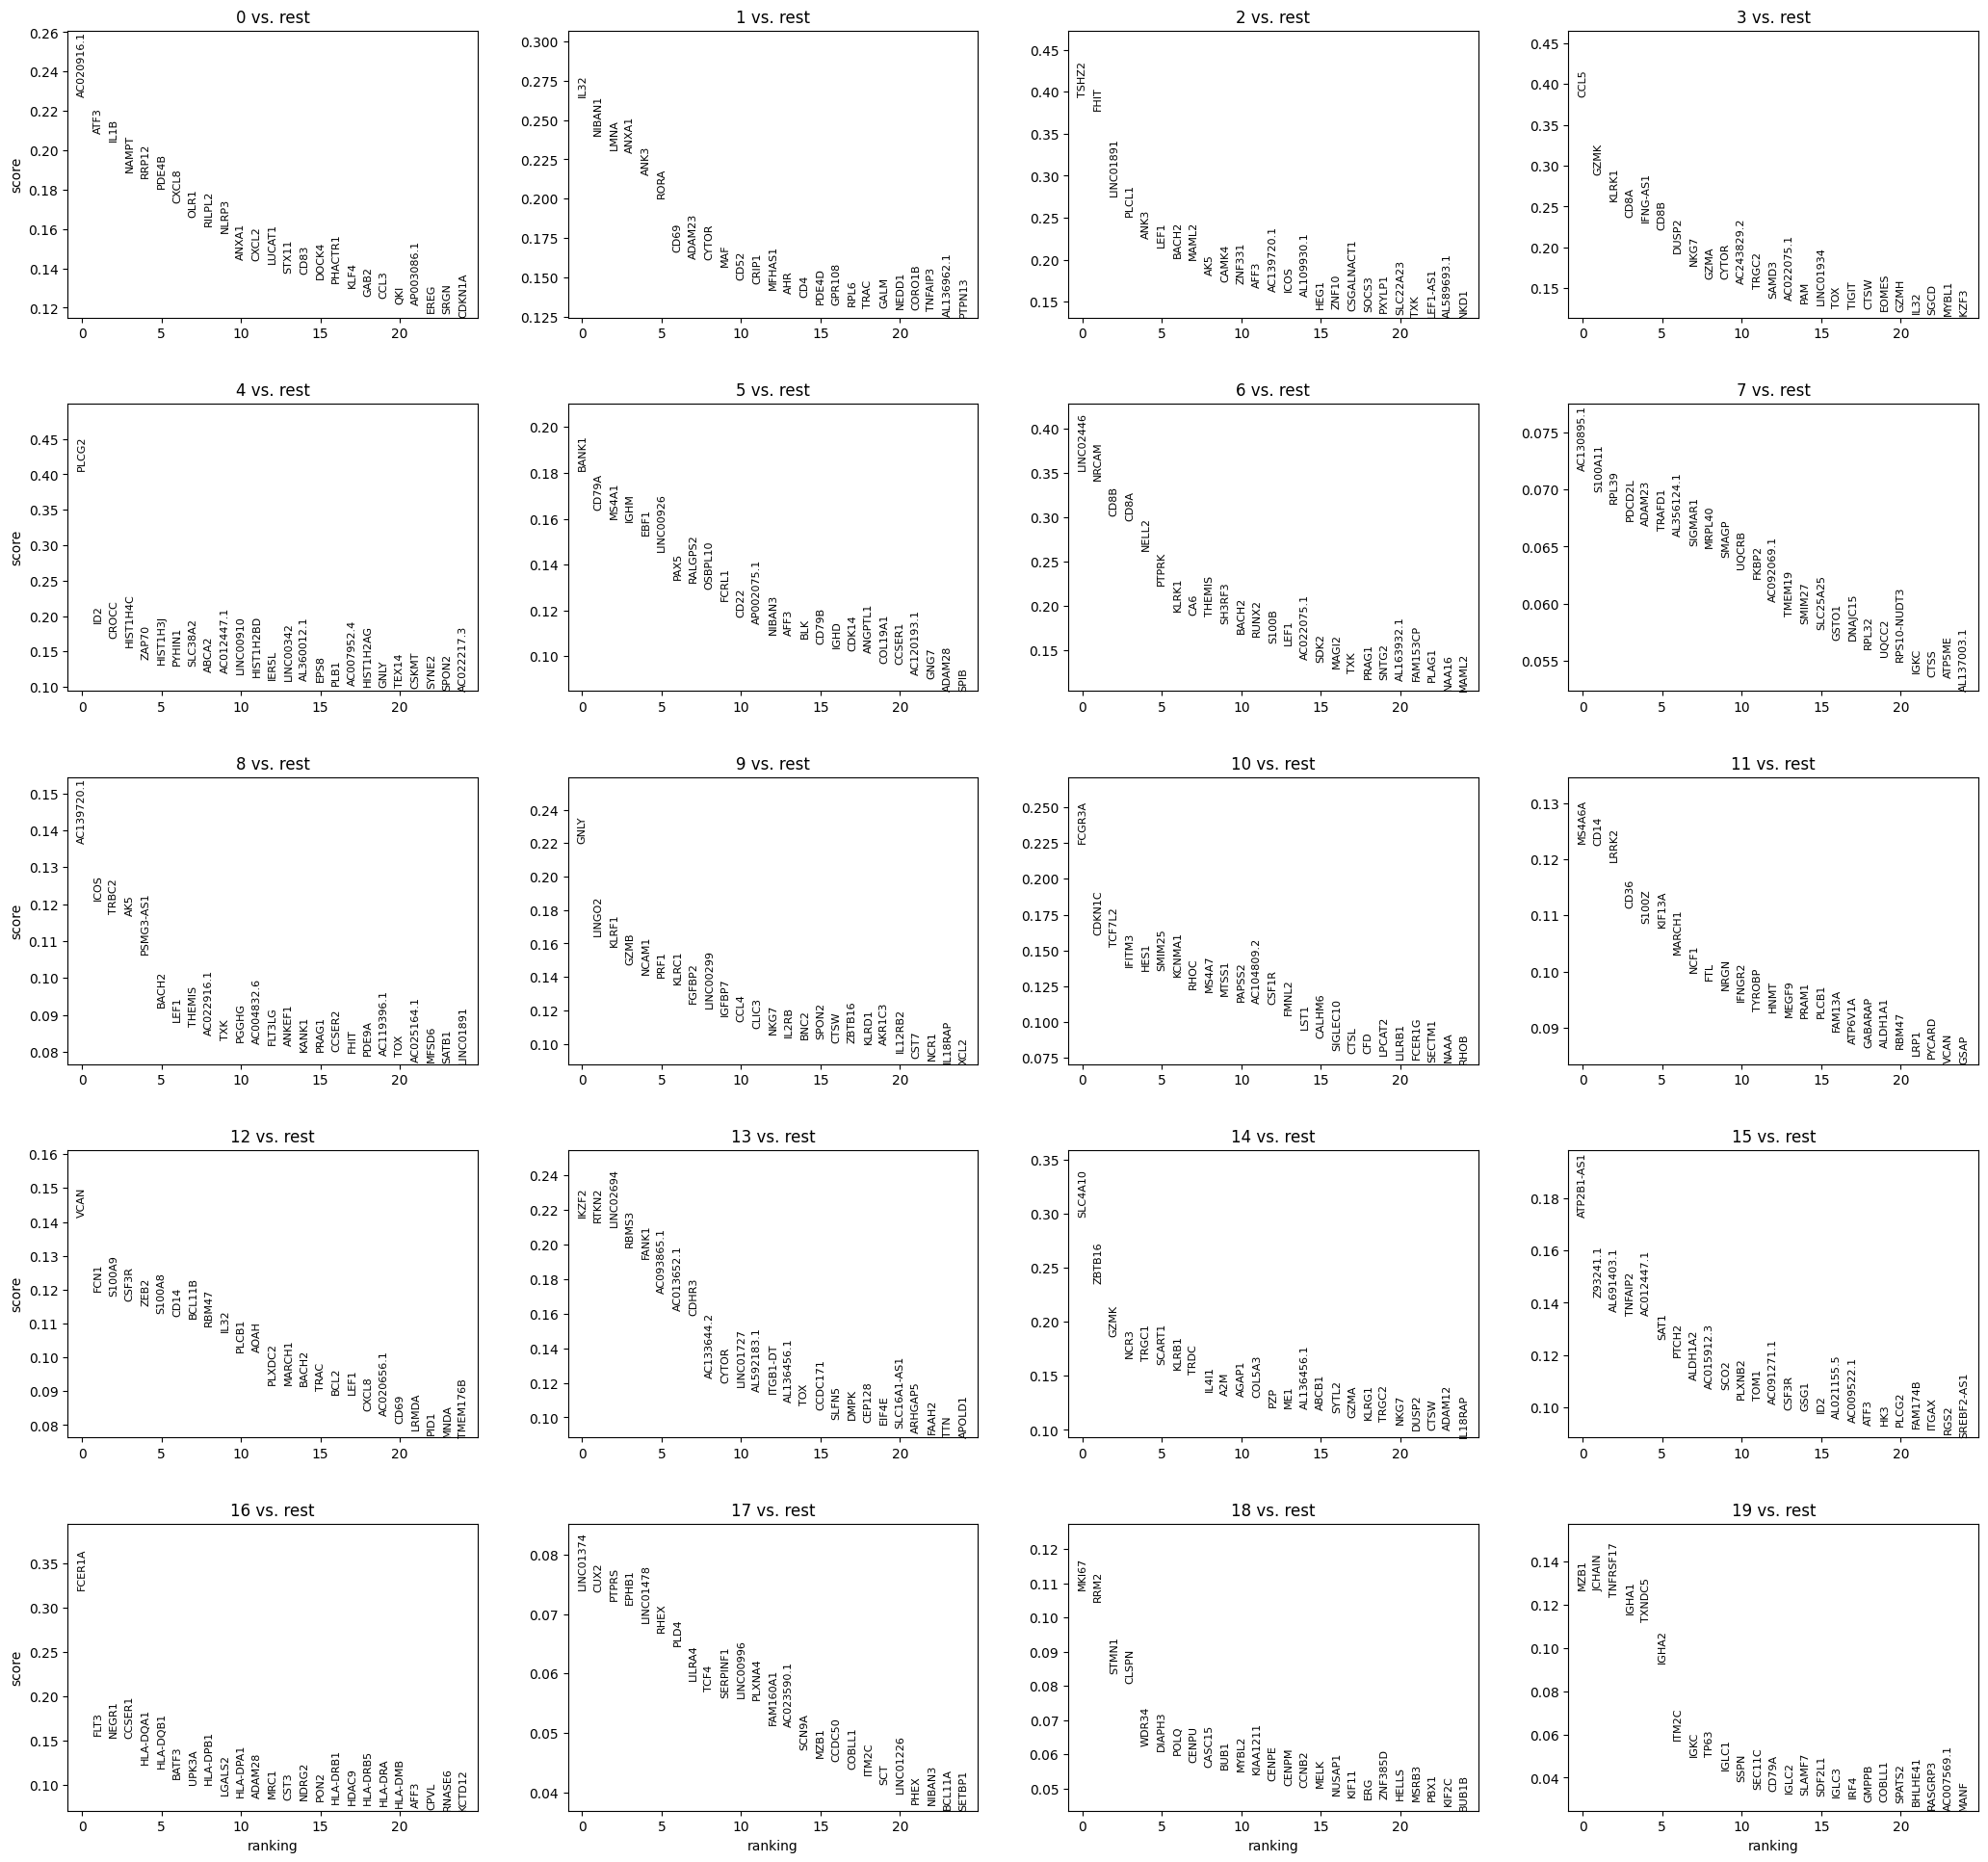

In [21]:
sc.tl.rank_genes_groups(SCANPY_adata_RNA, 'leiden', method='logreg')
sc.pl.rank_genes_groups(SCANPY_adata_RNA, n_genes=25, sharey=False)

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [23]:
clus = SCANPY_adata_RNA.obs.leiden
clus.write('snareRNA_clus.tsv')

AttributeError: 'Series' object has no attribute 'write'

In [45]:
SCANPY_adata_RNA.write('SCANPY_adata_RNA.h5ad')

# scATAC-seq processing and analysis

The scATAC-seq data analysis is analogous to the previous one, a part from the QC metrics which are specific to epigenetic data.
One needs to remember to binarize the matrix before going on with the processing.

In [27]:
epi.pp.binarize(SCANPY_adata_ATAC)
epi.pp.filter_cells(SCANPY_adata_ATAC, min_features=1)
epi.pp.filter_features(SCANPY_adata_ATAC, min_cells=1)

TypeError: unhashable type: 'list'

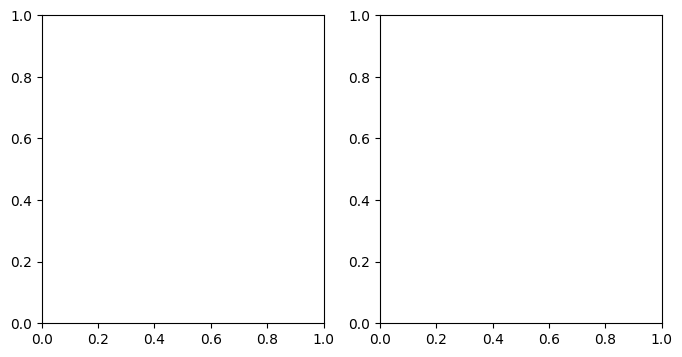

In [28]:
SCANPY_adata_ATAC.obs['log_nb_features'] = [np.log10(x) for x in SCANPY_adata_ATAC.obs['nb_features']]
epi.pl.violin(SCANPY_adata_ATAC, ['nb_features'])
epi.pl.violin(SCANPY_adata_ATAC, ['log_nb_features'])

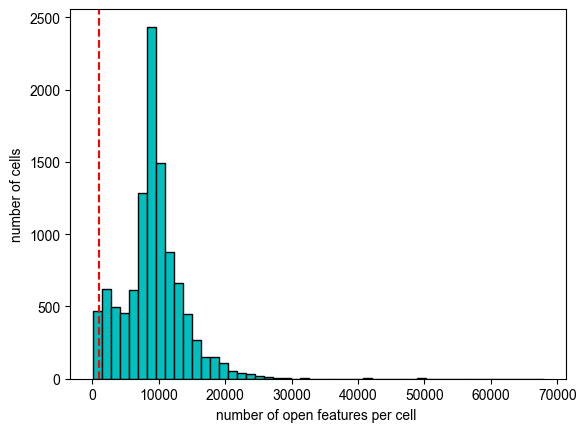

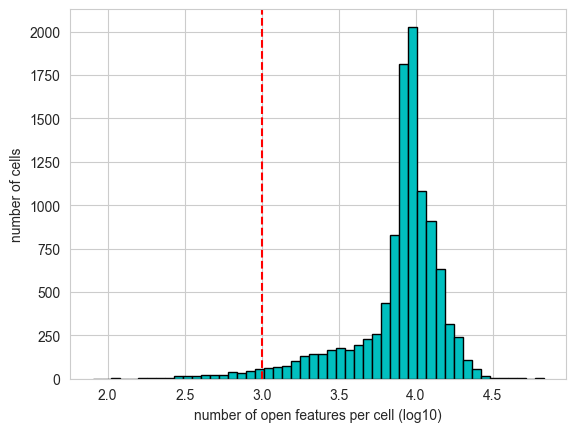

In [29]:
min_features = 1000

epi.pp.coverage_cells(SCANPY_adata_ATAC, binary=True, log=False, bins=50,
               threshold=min_features)
epi.pp.coverage_cells(SCANPY_adata_ATAC, binary=True, log=10, bins=50,
               threshold=min_features)

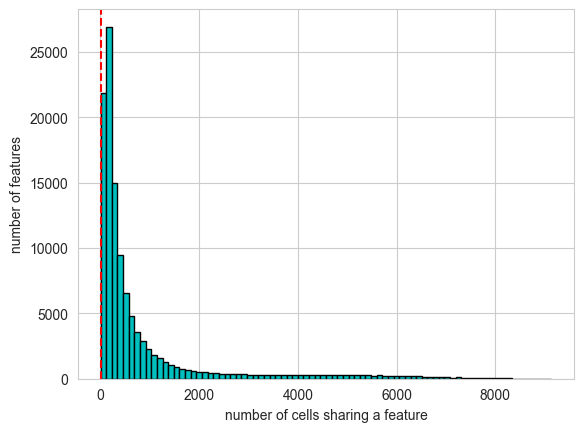

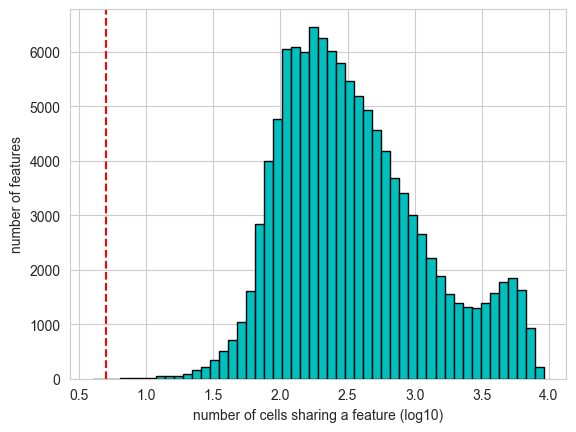

In [30]:
min_cells = 5
epi.pp.coverage_features(SCANPY_adata_ATAC, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(SCANPY_adata_ATAC, binary=True, log=True, 
                        threshold=min_cells)


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



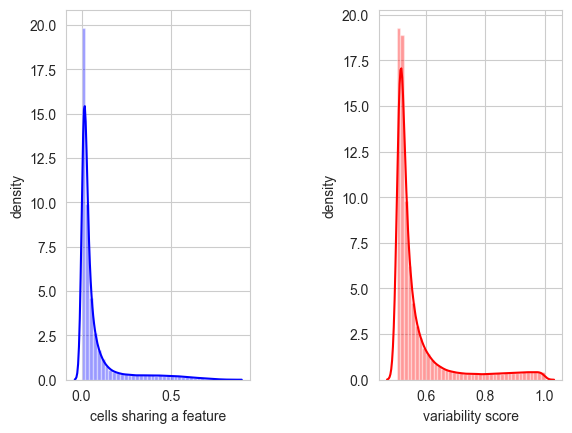

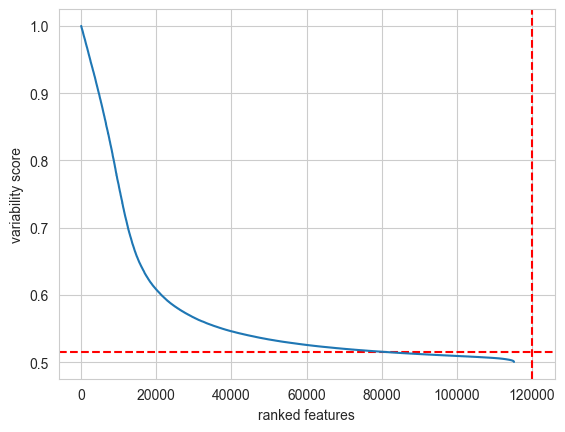

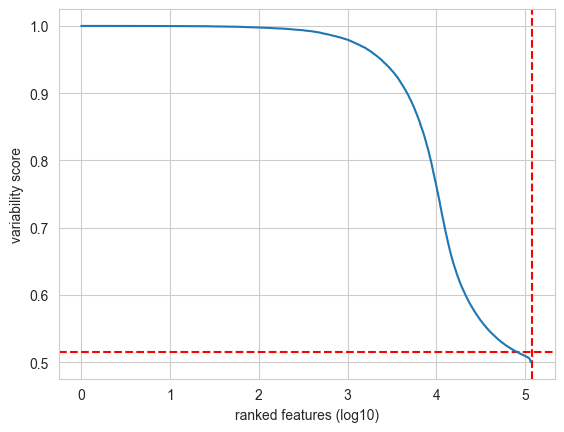

In [31]:
epi.pp.cal_var(SCANPY_adata_ATAC)
min_score_value = 0.515
nb_feature_selected = 120000
epi.pl.variability_features(SCANPY_adata_ATAC,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected
                     )

epi.pl.variability_features(SCANPY_adata_ATAC,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected
                     )


The workflow is analogous to the scRNA-seq and it is mainly carried on by the first function.

In [32]:
epi.pp.lazy(SCANPY_adata_ATAC)
SCANPY_adata_ATAC.layers['binary'] = SCANPY_adata_ATAC.X.copy()

In [33]:
epi.pp.normalize_total(SCANPY_adata_ATAC)
# save the current version of the matrix (normalised) in a layer of the Anndata.
SCANPY_adata_ATAC.layers['normalised'] = SCANPY_adata_ATAC.X.copy()

In [35]:
epi.pp.log1p(SCANPY_adata_ATAC)

In [ ]:
epi.pp.lazy(SCANPY_adata_ATAC)

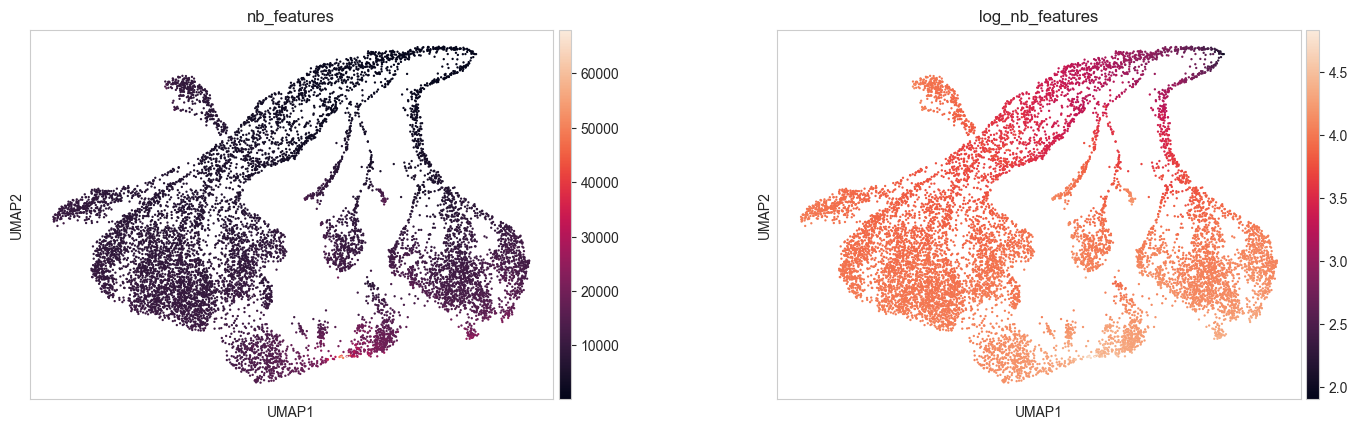

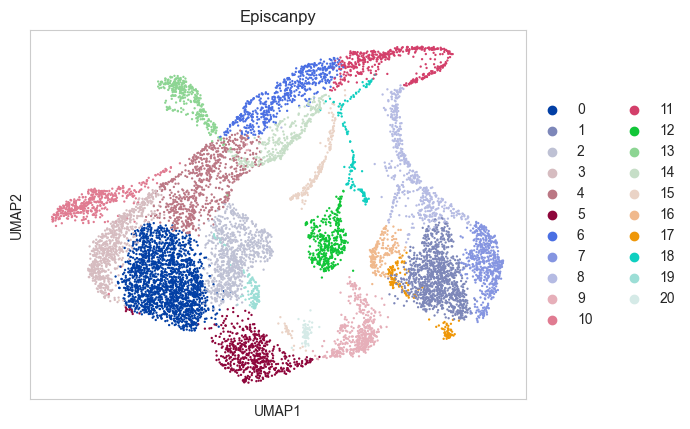

In [39]:
epi.pl.umap(SCANPY_adata_ATAC, color=['nb_features', 'log_nb_features'], wspace=0.3)
epi.tl.leiden(SCANPY_adata_ATAC, resolution=0.7)
epi.pl.umap(SCANPY_adata_ATAC, color = 'leiden', title="Episcanpy")

One obtain the final clustering, comparable with the previous one.

Given that Episcanpy is a fairly new package, there is not yet an easy way to create a Gene Activity Matrix, we skip this part of the multimodal analysis. One can find an insight on the notebooks related to the other pipelines.